## Lesson 04 - Pandas part 2

Welcome to lesson 5! In this lesson we will continue on with pandas as our main way of storing data. NumPy will be useful when we have a uniform multidimensional data set, but for now pandas will be our default.

Again, an exhaustive run through of pandas is too much for this class - see the book - [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) or the [official pandas website](http://pandas.pydata.org/pandas-docs/version/0.17.1/).

If you are familiar with [R](http://pandas.pydata.org/pandas-docs/version/0.17.1/comparison_with_r.html), [SAS](http://pandas.pydata.org/pandas-docs/version/0.17.1/comparison_with_sas.html), and/or [SQL](http://pandas.pydata.org/pandas-docs/version/0.17.1/comparison_with_sql.html), click on the links to lead you to the intro to pandas for users of each language.

Please download todays notebook [here](/pythoncourse/assets/notebooks/r&d/lesson 04.ipynb).

### Data Import

Importing data is the most important first step to get our data in. Today we will cover read_csv, before the end of the course we will talk about how to connect to your netezza (and other SQL) databases

In [1]:
from pandas import DataFrame, Series
import pandas as pd
import io
import numpy as np

We have a ton of ways of reading data into and writing data out of pandas. See the [dataIO page](http://pandas.pydata.org/pandas-docs/stable/io.html) for more details.

In [2]:
#using a string as example
#we could refer to file names if we had the file saved
data = '''
date,A,B,C
20090101,a,1,2
20090102,b,3,4
20090103,c,4,5
'''
print(data)


date,A,B,C
20090101,a,1,2
20090102,b,3,4
20090103,c,4,5



In [3]:
#by default, the index is arange(nrows)
pd.read_csv(io.StringIO(data))
#recall index objects: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Index.html

,date,A,B,C
0,20090101,a,1,2
1,20090102,b,3,4
2,20090103,c,4,5


In [38]:
#we can specify the index:
pd.read_csv(io.StringIO(data), index_col=0)
#also index_col='date'

,A,B,C
date,,,
20090101,a,1,2
20090102,b,3,4
20090103,c,4,5


In [4]:
#we can also use nested indices:
x = pd.read_csv(io.StringIO(data), index_col=['date','A'])
print(x)
print(x.loc[20090101])

            B  C
date     A      
20090101 a  1  2
20090102 b  3  4
20090103 c  4  5
   B  C
A      
a  1  2


In [5]:
#we can specify data type (it will speed things up, or avoid conversion)
pd.read_csv(io.StringIO(data), index_col=['date'], dtype={'A' : str, 'B':np.int32, 'C':np.float64})

,A,B,C
date,,,
20090101,a,1,2
20090102,b,3,4
20090103,c,4,5


In [6]:
#We can throw out names and use our own
pd.read_csv(io.StringIO(data), index_col=[0],
            dtype={'A' : str, 'B':np.int32, 'C':np.float64},
           names=["foo", 'bar', "baz"],
           header = 0)

,foo,bar,baz
20090101,a,1,2
20090102,b,3,4
20090103,c,4,5


In [7]:
#filter out some unneeded columns:
pd.read_csv(io.StringIO(data),
           names=['date', 'foo', 'bar', "baz"],
           header = 0,
           usecols = ['foo', 'baz'])

,foo,baz
0,a,2
1,b,4
2,c,5


In [8]:
#dates! more to come
dat = pd.read_csv(io.StringIO(data),
           parse_dates = True,
            index_col = [0]
           )
dat.index

DatetimeIndex(['2009-01-01', '2009-01-02', '2009-01-03'], dtype='datetime64[ns]', name='date', freq=None)

### Quick Review

I mentioned in the previous lecture we can use all our base and NumPy methods on pandas DataFrames: Here is a quick review taken from the SQL lesson:

In [9]:
tips = pd.read_csv('https://raw.github.com/pydata/pandas/master/pandas/tests/data/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


SQL select:
```
SELECT total_bill, tip, smoker, time
FROM tips
LIMIT 5;
```

In [10]:
tips[['total_bill', 'tip', 'smoker', 'time']].head(5)

,total_bill,tip,smoker,time
0,16.99,1.01,No,Dinner
1,10.34,1.66,No,Dinner
2,21.01,3.50,No,Dinner
3,23.68,3.31,No,Dinner
4,24.59,3.61,No,Dinner


SQL where:
```
SELECT *
FROM tips
WHERE time = 'Dinner' AND tip > 5.00;
LIMIT 5;
```

In [12]:
tips[(tips['time'] == 'Dinner') & (tips['tip'] > 5.00)].head(5)

,total_bill,tip,sex,smoker,day,time,size
23,39.42,7.58,Male,No,Sat,Dinner,4
44,30.40,5.60,Male,No,Sun,Dinner,4
47,32.40,6.00,Male,No,Sun,Dinner,4
52,34.81,5.20,Female,No,Sun,Dinner,4
59,48.27,6.73,Male,No,Sat,Dinner,4


### Groupby

Grouping and summarising data allows us to carry out the key data analysis steps of [split, apply, combine](https://www.jstatsoft.org/article/view/v040i01/v40i01.pdf). The journal article by Hadley Wickham was one of the first formalisations of the split apply combine paradigm, and we can of course do it in Python.

* Splitting the data into groups based on some criteria
* Applying a function to each group independently
* Combining the results into a data structure

Let's continue on with our analysis of the tips data:

In [13]:
tipsgroups = tips.groupby('sex')
tipsgroups

We now have a new data type, the groupby object.
We can access the attribute, groups. This is a dict, with each level as it's own entry and the indices of the original data frame:

In [16]:
for i,j in tipsgroups.groups.items():
    print(i)
print(tipsgroups.groups)

Male
Female
{'Male': [1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20, 23, 24, 25, 26, 27, 28, 30, 31, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 68, 69, 70, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 95, 96, 97, 98, 99, 105, 106, 107, 108, 110, 112, 113, 116, 120, 122, 123, 126, 129, 130, 138, 141, 142, 148, 149, 150, 151, 152, 153, 154, 156, 159, 160, 161, 163, 165, 166, 167, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 187, 189, 190, 192, 193, 194, 195, 196, 199, 200, 204, 206, 207, 208, 210, 211, 212, 216, 217, 218, 220, 222, 224, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 241, 242], 'Female': [0, 4, 11, 14, 16, 18, 21, 22, 29, 32, 33, 37, 51, 52, 57, 66, 67, 71, 72, 73, 74, 82, 85, 92, 93, 94, 100, 101, 102, 103, 104, 109, 111, 114, 115, 117, 118, 119, 121, 124, 125, 127, 128, 131, 132, 133, 134, 135, 136, 137, 139, 140, 143, 144, 145, 146, 147, 155, 1

We can do grouping on any axis, or with a custom function (this example is pathological):

In [24]:
def myfun(index):
    if len(index) >= 5:
        return 1
    else:
        return 0

group2 = tips.groupby(myfun, axis = 1)
group2.groups

{0: ['tip', 'sex', 'day', 'time', 'size'], 1: ['total_bill', 'smoker']}

We can use tab completion to see all our methods and attributes:

        total_bill       tip      size
sex                                   
Female   18.056897  2.833448  2.459770
Male     20.744076  3.089618  2.630573


C:\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3022: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  rot=rot, grid=grid, **kwds)


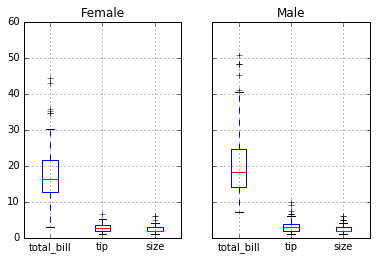

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
print(tipsgroups.mean())
tipsgroups.boxplot();

We can iterate through groups:

In [20]:
for name, group in tipsgroups:
    print(name)
    print(group.head(5))

Female
    total_bill   tip     sex smoker  day    time  size
0        16.99  1.01  Female     No  Sun  Dinner     2
4        24.59  3.61  Female     No  Sun  Dinner     4
11       35.26  5.00  Female     No  Sun  Dinner     4
14       14.83  3.02  Female     No  Sun  Dinner     2
16       10.33  1.67  Female     No  Sun  Dinner     3
Male
   total_bill   tip   sex smoker  day    time  size
1       10.34  1.66  Male     No  Sun  Dinner     3
2       21.01  3.50  Male     No  Sun  Dinner     3
3       23.68  3.31  Male     No  Sun  Dinner     2
5       25.29  4.71  Male     No  Sun  Dinner     4
6        8.77  2.00  Male     No  Sun  Dinner     2


To apply, we can use .aggregate:

In [22]:
tipsgroups.aggregate(np.mean)
#selecting columns:
tipsgroups['tip'].aggregate(np.mean)

sex
Female    2.833448
Male      3.089618
Name: tip, dtype: float64

In [23]:
#.agg is short for agg
tipsgroups.agg([np.mean, np.sum, np.std])

total_bill                          tip                        size  \
             mean      sum       std      mean     sum       std      mean   
sex                                                                          
Female  18.056897  1570.95  8.009209  2.833448  246.51  1.159495  2.459770   
Male    20.744076  3256.82  9.246469  3.089618  485.07  1.489102  2.630573   

                       
        sum       std  
sex                    
Female  214  0.937644  
Male    413  0.955997

In [58]:
#we can also use a dict, to do different things to different rows:
tipsgroups.agg({'tip': [np.mean, np.sum], 'size':lambda x: max(x)})
#see also .apply()

size       tip        
       <lambda>      mean     sum
sex                              
Female        6  2.833448  246.51
Male          6  3.089618  485.07

We can also filter, transform, plot, count etc etc. Take a look in the help for more details!

### Joins

We can use a variety of joins in pandas, the most basic using the concat function:

In [24]:
df1 = DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],
                    'B': ['B0', 'B1', 'B2', 'B3'],
                    'C': ['C0', 'C1', 'C2', 'C3'],
                    'D': ['D0', 'D1', 'D2', 'D3']},
                     index=[0, 1, 2, 3])
df2 = DataFrame({'A': ['A4', 'A5', 'A6', 'A7'],
                    'B': ['B4', 'B5', 'B6', 'B7'],
                    'C': ['C4', 'C5', 'C6', 'C7'],
                    'D': ['D4', 'D5', 'D6', 'D7']},
                     index=[4, 5, 6, 7])
#print(df1)
#print(df2)

In [25]:
#joins on index
pd.concat([df1, df2])

,A,B,C,D
0,A0,B0,C0,D0
1,A1,B1,C1,D1
2,A2,B2,C2,D2
3,A3,B3,C3,D3
4,A4,B4,C4,D4
5,A5,B5,C5,D5
6,A6,B6,C6,D6
7,A7,B7,C7,D7


In [26]:
#joins on index!
pd.concat([df1, df2], axis = 1)

,A,B,C,D,A,B,C,D
0,A0,B0,C0,D0,NaN,NaN,NaN,NaN
1,A1,B1,C1,D1,NaN,NaN,NaN,NaN
2,A2,B2,C2,D2,NaN,NaN,NaN,NaN
3,A3,B3,C3,D3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,A4,B4,C4,D4
5,NaN,NaN,NaN,NaN,A5,B5,C5,D5
6,NaN,NaN,NaN,NaN,A6,B6,C6,D6
7,NaN,NaN,NaN,NaN,A7,B7,C7,D7


In [27]:
#we can ignore the index!
df2.append(df1, ignore_index=True)
#df2.append(df1)

,A,B,C,D
0,A4,B4,C4,D4
1,A5,B5,C5,D5
2,A6,B6,C6,D6
3,A7,B7,C7,D7
4,A0,B0,C0,D0
5,A1,B1,C1,D1
6,A2,B2,C2,D2
7,A3,B3,C3,D3


For more control, we might want to explicitly use merge!

We have the standard joins - inner, outer, left, right, full and union:

In [28]:
df1 = DataFrame({'key': ['A', 'B', 'C', 'D'],
                 'value': np.random.randn(4)})
df2 = pd.DataFrame({'key': ['B', 'D', 'D', 'E'],
                    'value': np.random.randn(4)})
#SQL:
#SELECT *
#FROM df1
#INNER JOIN df2
#  ON df1.key = df2.key;
pd.merge(df1, df2, on='key')
#SQL:
#SELECT *
#FROM df1
#LEFT OUTER JOIN df2
#  ON df1.key = df2.key;
pd.merge(df1, df2, on='key', how='left')
#SQL:
#SELECT *
#FROM df1
#RIGHT OUTER JOIN df2
#  ON df1.key = df2.key;
pd.merge(df1, df2, on='key', how='right')
#SQL:
#SELECT *
#FROM df1
#FULL OUTER JOIN df2
#  ON df1.key = df2.key;
pd.merge(df1, df2, on='key', how='outer')

,key,value_x,value_y
0,A,-1.306885,NaN
1,B,-0.837557,0.452174
2,C,1.426844,NaN
3,D,0.115072,-0.669762
4,D,0.115072,0.172322
5,E,NaN,0.451408


We have not covered a bunch of stuff: [Pivot tables and reshaping](http://pandas.pydata.org/pandas-docs/stable/reshaping.html), [window functions (which were completely updated yesterday)](http://pandas.pydata.org/pandas-docs/version/0.18.0/whatsnew.html#whatsnew-0180-enhancements-moments) and [time series](http://pandas.pydata.org/pandas-docs/stable/timeseries.html). We will cover these as we continue throughout the course.

### Example

From here, we will look at a worked example of data analysis using pandas. In the first lesson, we looked at the example of the tennis fixing scandal, and briefly ran through it. Now we have the skills and knowledge to walk through it, and assess the analysis.

Here's the link to the [original article](http://www.buzzfeed.com/heidiblake/the-tennis-racket) and the [notebook on github](https://github.com/BuzzFeedNews/2016-01-tennis-betting-analysis) 